In [135]:
import tifffile
from univread import read as imread

import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, disk
from skimage.exposure import rescale_intensity

import albumentations as A
from src.augmentations import medium_aug_rot

from imgviz import label2rgb

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
img = imread('/mnt/data/decathlon/Task01_BrainTumour/train/volumes/BRATS_001.tif')
lbl = imread('/mnt/data/decathlon/Task01_BrainTumour/train/labels/BRATS_001.tif')

In [136]:
img = np.moveaxis(np.moveaxis(imread('/mnt/data/decathlon/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz'), 
                              2, 0), 
                  -1, 0)
img = rescale_intensity(img, out_range=(0, 255)).astype(np.uint8)
lbl = np.moveaxis(imread('/mnt/data/decathlon/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz'), -1, 0)

In [79]:
img = imread('/mnt/data/decathlon/Task03_Liver/train/volumes/liver_0.tif')
lbl = imread('/mnt/data/decathlon/Task03_Liver/train/labels/liver_0.tif')

In [141]:
img = np.moveaxis(imread('/mnt/data/decathlon/Task03_Liver/imagesTr/liver_0.nii.gz'), 2, 0)
img = rescale_intensity(img, out_range=(0, 255)).astype(np.uint8)
lbl = np.moveaxis(imread('/mnt/data/decathlon/Task03_Liver/labelsTr/liver_0.nii.gz'), -1, 0)

In [148]:
il = lbl.sum((1,2)) > 0
if len(img.shape) == 4:
    img = img[:, il]
else:
    img = img[il]
lbl = lbl[il]

In [189]:
label_transform = A.Compose([
                             A.GridDistortion(p=0.5, distort_limit=0.3), 
                             A.Cutout(p=0.5, max_h_size=16, max_w_size=16), 
                             A.ShiftScaleRotate(shift_limit=0.01, rotate_limit=5, scale_limit=0.01, p=0.3)
                            ])

together_transform = A.Compose([
                      A.CropNonEmptyMaskIfExists(256, 256),
                      A.OneOf([A.Blur(blur_limit=5),
                             A.MedianBlur(blur_limit=5),
                             A.MotionBlur(blur_limit=5)], p=0.5),
                      A.OneOf([A.CLAHE(),
                             A.Equalize()], p=0.2),
                      A.OneOf([A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                             A.RandomGamma(gamma_limit=(90, 110))], p=0.5),
                      A.OneOf([A.GridDistortion(distort_limit=0.2),
                             A.GlassBlur(max_delta=5)], p=0.5),
                      A.GaussNoise(var_limit=(20, 50), p=0.5)
                            ], p=0.99, additional_targets={'mask2': 'mask'})

In [254]:
from skimage.segmentation import felzenszwalb
def fel_overseg(img, lbl):
    subsegs = felzenszwalb(img)
    nlbl = np.copy(lbl)
    for i in np.unique(subsegs):
        if lbl[subsegs == i].mean() > 0.5:
            nlbl[subsegs == i] = 1
    
    return nlbl

def get_label(img, lbl, i):
    trg_lbl = lbl[i]
    inp_img = img[i]
    
    if len(img.shape) == 4:
        img = img[np.random.randint(len(img))]
    
    if np.random.rand() < 0.3:
        inp_lbl = lbl[i+np.random.randint(-3,3)]
    else:
        inp_lbl = lbl[i]
    
    inp_lbl = label_transform(image=inp_img, mask=inp_lbl)['mask']
        
    if np.random.rand() < 0.3:
        inp_lbl = binary_erosion(inp_lbl, footprint=disk(np.random.randint(5, 20))).astype(np.uint8)
    
    if np.random.rand() < 0.3:
        inp_lbl = fel_overseg(inp_img, inp_lbl)
    
    cls = np.random.choice(np.unique(trg_lbl)[1:])
    trg_lbl = (trg_lbl == cls).astype(np.uint8)
    inp_lbl = (inp_lbl == cls).astype(np.uint8)
    
    full_transformed = together_transform(image=inp_img, mask=trg_lbl, mask2=inp_lbl)
    return full_transformed['image'], full_transformed['mask'], full_transformed['mask2']

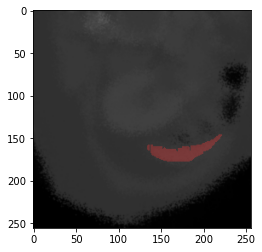

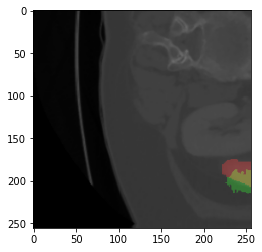

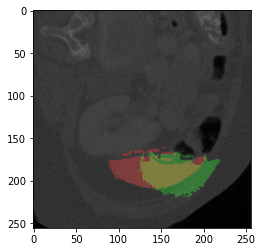

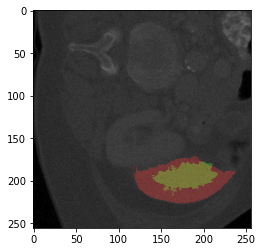

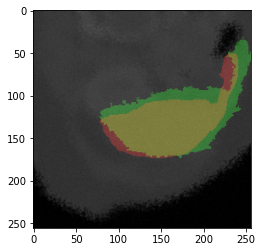

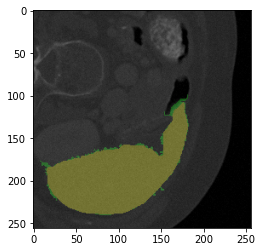

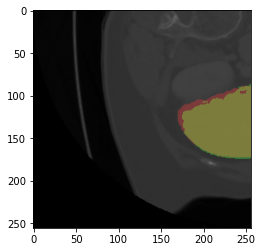

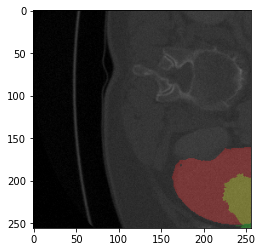

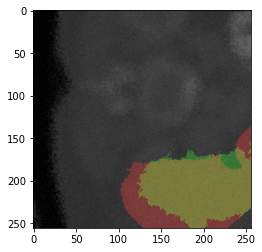

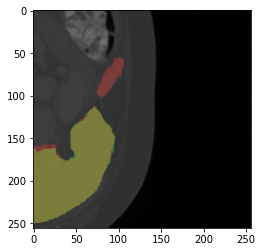

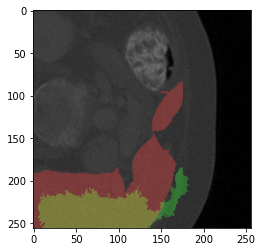

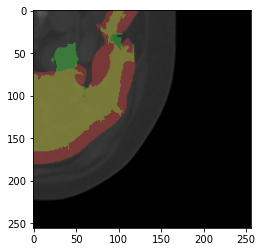

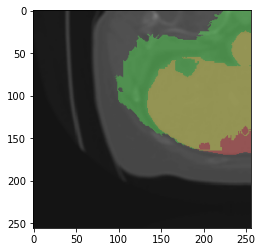

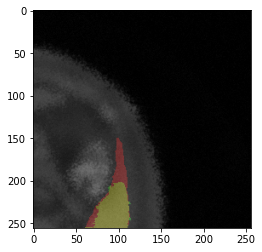

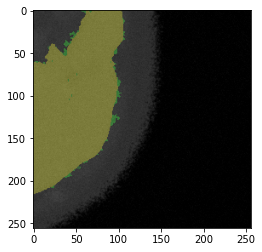

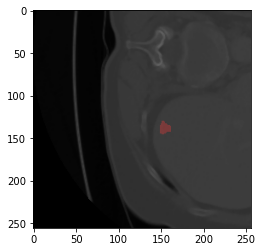

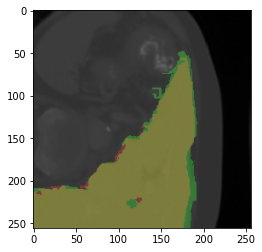

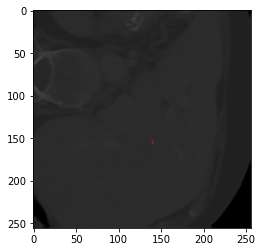

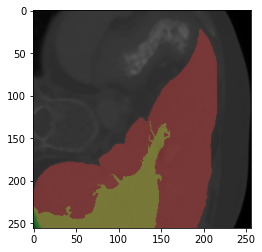

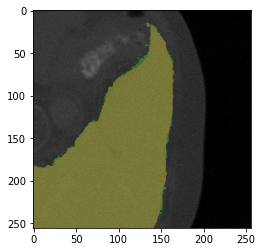

In [255]:
for i in range(20):
    res = get_label(img, lbl, i)
    plt.imshow(label2rgb(fel_overseg(res[0], res[2])*2+res[1], res[0]))
    plt.show()